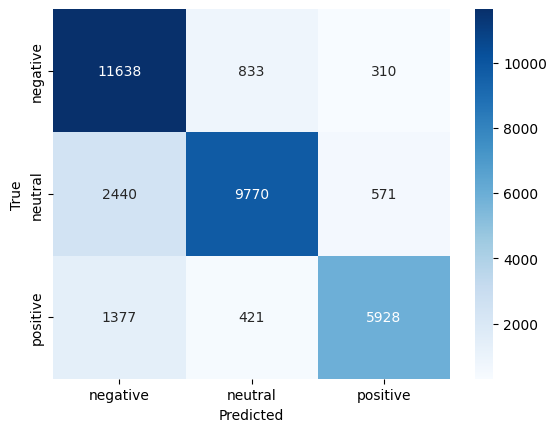


Classification Report:
              precision    recall  f1-score   support

    negative     0.7530    0.9106    0.8243     12781
     neutral     0.8862    0.7644    0.8208     12781
    positive     0.8706    0.7673    0.8157      7726

    accuracy                         0.8212     33288
   macro avg     0.8366    0.8141    0.8203     33288
weighted avg     0.8315    0.8212    0.8210     33288

Macro F1-score: 0.8202866527440644


In [21]:
import re
import string
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

data = pd.read_csv(r"C:\Users\taras\OneDrive\Desktop\CV_projects\Amazon_reviews_analysis\data\amazon_reviews.csv")
data['content'] = data['content'].fillna("")

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['content'] = data['content'].apply(clean_text)

def categorize_score(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

data['score_cat'] = data['score'].apply(categorize_score)

negative = data[data['score_cat'] == 'negative']
neutral = data[data['score_cat'] == 'neutral']
positive = data[data['score_cat'] == 'positive']

neutral_upsampled = resample(neutral,
                             replace=True,
                             n_samples=max(len(negative), len(positive)),
                             random_state=101)

data_balanced = pd.concat([negative, positive, neutral_upsampled])

train_X, test_X, train_y, test_y = train_test_split(
    data_balanced['content'], data_balanced['score_cat'],
    test_size=0.3,
    random_state=101,
    stratify=data_balanced['score_cat']
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5, ngram_range=(1,2))),
    ('nb', MultinomialNB(alpha=0.1)),
])

pipeline.fit(train_X, train_y)
predictions = pipeline.predict(test_X)

cm = confusion_matrix(test_y, predictions, labels=['negative','neutral','positive'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(test_y, predictions, digits=4))
print("Macro F1-score:", f1_score(test_y, predictions, average='macro'))


In [ ]:
# advanced_amazon_review_classifier.py

import pandas as pd
import re
import string
import nltk
import torch
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

# -----------------------
# Setup NLTK
# -----------------------
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# -----------------------
# Load Data
# -----------------------
data = pd.read_csv(r"C:\Users\taras\OneDrive\Desktop\CV_projects\Amazon_reviews_analysis\data\amazon_reviews.csv")
data['content'] = data['content'].fillna("")

# -----------------------
# NLTK Text Cleaning
# -----------------------
def clean_text_nltk(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return " ".join(tokens)

data['cleaned'] = data['content'].apply(clean_text_nltk)

# -----------------------
# Categorize Scores
# -----------------------
def categorize_score(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

data['score_cat'] = data['score'].apply(categorize_score)

# -----------------------
# Handle Class Imbalance (Upsample Neutral)
# -----------------------
negative = data[data['score_cat'] == 'negative']
neutral = data[data['score_cat'] == 'neutral']
positive = data[data['score_cat'] == 'positive']

neutral_upsampled = resample(neutral,
                             replace=True,
                             n_samples=max(len(negative), len(positive)),
                             random_state=42)

data_balanced = pd.concat([negative, positive, neutral_upsampled]).sample(frac=1, random_state=42)

# -----------------------
# Train/Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    data_balanced['cleaned'],
    data_balanced['score_cat'],
    test_size=0.3,
    stratify=data_balanced['score_cat'],
    random_state=42
)

# -----------------------
# TF-IDF + Naive Bayes Pipeline
# -----------------------
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5, ngram_range=(1,2))),
    ('nb', MultinomialNB(alpha=0.1))
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

# -----------------------
# Evaluation NB
# -----------------------
cm = confusion_matrix(y_test, y_pred_nb, labels=['negative','neutral','positive'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, digits=4))
print("Macro F1-score:", f1_score(y_test, y_pred_nb, average='macro'))

# -----------------------
# Optional: Transformers Embeddings + Logistic Regression
# -----------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def encode_text(texts, max_len=128):
    tokens = tokenizer(texts.tolist(), padding=True, truncation=True,
                       max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:,0,:].numpy()  # CLS token embeddings

# Encode training and test sets (can take some time)
X_train_emb = encode_text(X_train)
X_test_emb = encode_text(X_test)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_emb, y_train)
y_pred_emb = clf.predict(X_test_emb)

# -----------------------
# Evaluation Transformers
# -----------------------
cm_emb = confusion_matrix(y_test, y_pred_emb, labels=['negative','neutral','positive'])
sns.heatmap(cm_emb, annot=True, fmt="d", cmap="Greens",
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BERT Embeddings + Logistic Regression")
plt.show()

print("Transformers + Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_emb, digits=4))
print("Macro F1-score:", f1_score(y_test, y_pred_emb, average='macro'))


ModuleNotFoundError: No module named 'nltk'

  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached charset_normalizer-3.4.4-cp313-cp313-win_amd64.whl.metadata (38 kB)
  Using cached idna-3.11-py3-none-an